# Gridsearching a Decision Tree & Random Forest, to find best hyperparameter values

The purpose of this notebook is to discover the best type of tree-based model and the ideal hyperparameters a long with it. The general strategy is to iterate through a series of gridsearches that become increasingly narrow and continue iterating until F1-score begins to decrease instead of increase. 

As mentioned in the [previous notebook](./resampling.ipynb), I am using the F1-score here as my primary performance metric because it is more important to correctly classify the target class as much as possible than it is to maximize true predictions across both classes of the target feature (i.e. accuracy), and it is not necessarily a liability to the business to have a occasional missclassification of the non-target class. Furthermore, there is not an argument obvious to me to prioritize either precision or recall over the other.  Therefore, I rely on F1-score to evaluate and rank the models in this notebook. 

## Import dependencies, load data

In [5]:
from preprocessor import data_cleaner, data_sampler
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, roc_curve,auc, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})


In [6]:
# data cleaning and OHE 
X_train, y_train = data_cleaner("../data/train.csv.zip")
X_test, y_test = data_cleaner("../data/test.csv.zip")


In [7]:
# resample training data
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train,y_train)

## Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

### First gridsearch
My best guess at a range of values to test

In [9]:
dtc_grid = DecisionTreeClassifier()

# define parameter grid to search
grid = [
    {'criterion': ['gini', 'entropy', 'log_loss'], 
    'splitter': ['best','random'], 
    'max_depth': [2,5,10],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,5,10],
    'max_features':[None,'auto'],
    'max_leaf_nodes':[10,50,100]}
]

gridsearch = GridSearchCV(estimator=dtc_grid,param_grid=grid,scoring='f1',cv=5,n_jobs=3)
gridsearch.fit(X_train,y_train)

grid_pred = gridsearch.predict(X_test)
grid_report = classification_report(y_test,grid_pred,output_dict=True)
grid_report = pd.DataFrame(grid_report).iloc[:,0:3]
grid_report

,0.0,1.0,accuracy
precision,0.984225,0.778589,0.938674
recall,0.939840,0.933528,0.938674
f1-score,0.961521,0.849048,0.938674
support,21177.000000,4799.000000,0.938674


In [10]:
gridsearch.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

### second gridsearch
The values with the greatest magnitude were chosen for Max_depth, max_features,max_leaf_nodes,min_samples_leaf.
So the next gridsearch will include these chosen values as the low end of the range that is being searched. 

In [11]:
grid_two = [
    {'criterion': ['gini'],
    'max_depth': [10,25,50],
    'max_features': ['log2',10,20],
    'max_leaf_nodes': [100,150,200],
    'min_samples_leaf': [10,25,50],
    'min_samples_split': [2],
    'splitter': ['best']}
]

gridsearch_two = GridSearchCV(estimator=dtc_grid,param_grid=grid_two,scoring='f1',cv=5,n_jobs=3)
gridsearch_two.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=3,
             param_grid=[{'criterion': ['gini'], 'max_depth': [10, 25, 50],
                          'max_features': ['log2', 10, 20],
                          'max_leaf_nodes': [100, 150, 200],
                          'min_samples_leaf': [10, 25, 50],
                          'min_samples_split': [2], 'splitter': ['best']}],
             scoring='f1')

In [12]:

grid_two_pred = gridsearch_two.predict(X_test)
grid_two_report = classification_report(y_test,grid_two_pred,output_dict=True)
grid_two_report = pd.DataFrame(grid_two_report).iloc[:,0:3]
grid_two_report

,0.0,1.0,accuracy
precision,0.981606,0.865686,0.958847
recall,0.967654,0.919983,0.958847
f1-score,0.974580,0.892009,0.958847
support,21177.000000,4799.000000,0.958847


In [13]:
gridsearch_two.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 20,
 'max_leaf_nodes': 200,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'splitter': 'best'}

### third gridsearch
Max_depth, max_leaf_nodes, continue selecting the greatest value. Max_features is still unclear. 

In [14]:
grid_three = [
    {'criterion': ['gini'],
    'max_depth': [50,100,200],
    'max_features': [15,20,23],
    'max_leaf_nodes': [200,300,500],
    'min_samples_leaf': [10],
    'min_samples_split': [2],
    'splitter': ['best']}
    ]

gridsearch_three = GridSearchCV(estimator=dtc_grid,param_grid=grid_three,scoring='f1',cv=5,n_jobs=3)
gridsearch_three.fit(X_train,y_train)

grid_three_pred = gridsearch_three.predict(X_test)
grid_three_report = classification_report(y_test,grid_three_pred,output_dict=True)
grid_three_report = pd.DataFrame(grid_three_report).iloc[:,0:3]
grid_three_report

,0.0,1.0,accuracy
precision,0.984336,0.910554,0.970396
recall,0.979270,0.931236,0.970396
f1-score,0.981797,0.920779,0.970396
support,21177.000000,4799.000000,0.970396


In [15]:
gridsearch_three.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 20,
 'max_leaf_nodes': 500,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'splitter': 'best'}

### fourth gridsearch
Everything seems to be getting zeroed in on except for max_leaf_nodes.

In [16]:
grid_four = [
    {'criterion': ['gini'],
    'max_depth': [75,100,125],
    'max_features': [18,19,20],
    'max_leaf_nodes': [500,750,1000],
    'min_samples_leaf': [5,10,15],
    'min_samples_split': [2],
    'splitter': ['best']}
    ]

gridesearch_four = GridSearchCV(estimator=dtc_grid,param_grid=grid_four,scoring='f1',cv=5,n_jobs=3)
gridesearch_four.fit(X_train,y_train)

grid_four_pred = gridesearch_four.predict(X_test)
grid_four_report = classification_report(y_test,grid_four_pred,output_dict=True)
grid_four_report = pd.DataFrame(grid_four_report).iloc[:,0:3]
grid_four_report

,0.0,1.0,accuracy
precision,0.985142,0.913646,0.971628
recall,0.979978,0.934778,0.971628
f1-score,0.982553,0.924091,0.971628
support,21177.000000,4799.000000,0.971628


In [17]:
gridesearch_four.best_params_

{'criterion': 'gini',
 'max_depth': 75,
 'max_features': 19,
 'max_leaf_nodes': 1000,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'splitter': 'best'}

### fifth gridsearch

In [18]:
grid_five = [
    {'criterion': ['gini'],
    'max_depth': [115,125,150,175],
    'max_features': [19],
    'max_leaf_nodes': [600,750,900],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'splitter': ['best']}
    ]

gridsearch_five = GridSearchCV(estimator=dtc_grid,param_grid=grid_five,scoring='f1',cv=5,n_jobs=3)
gridsearch_five.fit(X_train,y_train)

grid_five_pred = gridsearch_five.predict(X_test)
grid_five_report = classification_report(y_test,grid_five_pred,output_dict=True)
grid_five_report = pd.DataFrame(grid_five_report).iloc[:,0:3]
grid_five_report

,0.0,1.0,accuracy
precision,0.985383,0.915596,0.972205
recall,0.980450,0.935820,0.972205
f1-score,0.982910,0.925598,0.972205
support,21177.000000,4799.000000,0.972205


In [19]:
gridsearch_five.best_params_

{'criterion': 'gini',
 'max_depth': 115,
 'max_features': 19,
 'max_leaf_nodes': 750,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'splitter': 'best'}

### sixth gridsearch

In [20]:
grid_six = [
    {'criterion': ['gini'],
    'max_depth': [125,135,150],
    'max_features': [19],
    'max_leaf_nodes': [550,600,650],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'splitter': ['best']}
    ]

gridsearch_six = GridSearchCV(estimator=dtc_grid,param_grid=grid_six,scoring='f1',cv=5,n_jobs=3)
gridsearch_six.fit(X_train,y_train)

grid_six_pred = gridsearch_six.predict(X_test)
grid_six_report = classification_report(y_test,grid_six_pred,output_dict=True)
grid_six_report = pd.DataFrame(grid_six_report).iloc[:,0:3]
grid_six_report

,0.0,1.0,accuracy
precision,0.985733,0.921910,0.973745
recall,0.982009,0.937279,0.973745
f1-score,0.983867,0.929531,0.973745
support,21177.000000,4799.000000,0.973745


### Observations:
F1, precision, and recall performance continue to decrease after the fourth gridsearch. So, the the best_params_ of gridsearch_four will be used as a start point to gridsearch a random forest and bagging tree. 

Gridsearch_four.best_params_ returns the following dict:  
{'criterion': 'gini',  
 'max_depth': 125,  
 'max_features': 19,  
 'max_leaf_nodes': 750,  
 'min_samples_leaf': 5,  
 'min_samples_split': 2,  
 'splitter': 'best'}  

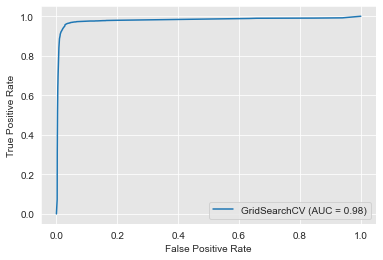

In [21]:
plot_roc_curve(gridesearch_four,X_test,y_test)
plt.show()

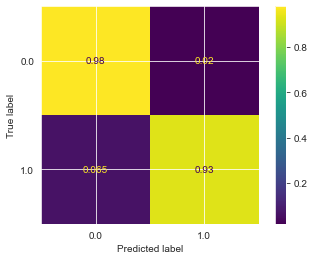

In [22]:
plot_confusion_matrix(gridesearch_four,X_test,y_test,normalize='true')
plt.show()

## BaggingClassifier

### baseline model (default bagging parameters)

In [23]:
bagging_tree = DecisionTreeClassifier(criterion='gini',
                                        max_depth=125,
                                        max_features=19,
                                        max_leaf_nodes=750,
                                        min_samples_leaf=5,
                                        min_samples_split=2,
                                        splitter='best')
                                        
tree_bagger = BaggingClassifier(base_estimator=bagging_tree)
tree_bagger.fit(X_train,y_train)
tree_bagger_pred = tree_bagger.predict(X_test)
tree_bagger_report = classification_report(y_test,tree_bagger_pred,output_dict=True)
tree_bagger_report = pd.DataFrame(tree_bagger_report).iloc[:,0:3]
tree_bagger_report


,0.0,1.0,accuracy
precision,0.988384,0.932242,0.977826
recall,0.984370,0.948948,0.977826
f1-score,0.986373,0.940520,0.977826
support,21177.000000,4799.000000,0.977826


### Gridsearch bagging classifier

#### First gridsearch

In [24]:
from sklearn.ensemble import BaggingClassifier

bagging_tree = DecisionTreeClassifier(criterion='gini',
                                        max_depth=125,
                                        max_features=19,
                                        max_leaf_nodes=750,
                                        min_samples_leaf=5,
                                        min_samples_split=2,
                                        splitter='best')

tree_bagger = BaggingClassifier()

bag_grid = [{
    'base_estimator':[bagging_tree], 
    'n_estimators':[5,10,15,20], 
    'max_samples':[1.0,3.0,5.0], 
    'max_features':[1.0,5.0,10.0],
    'bootstrap':[True,False],
    'bootstrap_features':[True,False], 
    'n_jobs':[3]
}]

bagged_grid = GridSearchCV(estimator=tree_bagger,param_grid=bag_grid,scoring='f1',n_jobs=3)
bagged_grid.fit(X_train,y_train)
bagged_grid_pred = bagged_grid.predict(X_test)
bagged_grid_report = classification_report(y_test,bagged_grid_pred,output_dict=True)
bagged_grid_report = pd.DataFrame(bagged_grid_report).iloc[:,0:3]
bagged_grid_report


,0.0,1.0,accuracy
precision,0.988602,0.943295,0.980174
recall,0.987061,0.949781,0.980174
f1-score,0.987831,0.946527,0.980174
support,21177.000000,4799.000000,0.980174


In [25]:
bagged_grid_report

,0.0,1.0,accuracy
precision,0.988602,0.943295,0.980174
recall,0.987061,0.949781,0.980174
f1-score,0.987831,0.946527,0.980174
support,21177.000000,4799.000000,0.980174


In [26]:
bagged_grid.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=125, max_features=19, max_leaf_nodes=750,
                        min_samples_leaf=5),
 'bootstrap': False,
 'bootstrap_features': True,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 15,
 'n_jobs': 3}

#### Second gridsearch 
-searching only n_estimators

In [27]:
second_bag_grid = [{
    'base_estimator':[bagging_tree], 
    'n_estimators':[20,23,25,30], 
    'max_samples':[1.0], 
    'max_features':[1.0],
    'bootstrap':[False],
    'bootstrap_features':[True], 
    'n_jobs':[3]
}]

second_bagged_grid = GridSearchCV(estimator=tree_bagger,param_grid=second_bag_grid,scoring='f1',n_jobs=3)
second_bagged_grid.fit(X_train,y_train)
second_bagged_grid_pred = second_bagged_grid.predict(X_test)
second_bagged_grid_report = classification_report(y_test,second_bagged_grid_pred,output_dict=True)
second_bagged_grid_report = pd.DataFrame(second_bagged_grid_report).iloc[:,0:3]
second_bagged_grid_report

,0.0,1.0,accuracy
precision,0.989982,0.933849,0.979366
recall,0.984653,0.956033,0.979366
f1-score,0.987311,0.944811,0.979366
support,21177.000000,4799.000000,0.979366


In [28]:
second_bagged_grid.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=125, max_features=19, max_leaf_nodes=750,
                        min_samples_leaf=5),
 'bootstrap': False,
 'bootstrap_features': True,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 25,
 'n_jobs': 3}

#### finding best n_estimators
Here I re-run the same cell(s) adjusting only n_estimators to find the value that improves F1 the most. 

In [29]:
n_trees_bagger = BaggingClassifier(base_estimator=bagging_tree,
                                    bootstrap=False,
                                    bootstrap_features=True,
                                    n_estimators=31,
                                    n_jobs=3)

n_trees_bagger.fit(X_train,y_train)

n_trees_pred = n_trees_bagger.predict(X_test)
n_trees_report = classification_report(y_test,n_trees_pred,output_dict=True)
n_trees_report = pd.DataFrame(n_trees_report).iloc[:,0:3]
n_trees_report

,0.0,1.0,accuracy
precision,0.989921,0.947129,0.981945
recall,0.987911,0.955616,0.981945
f1-score,0.988915,0.951354,0.981945
support,21177.000000,4799.000000,0.981945


#### Observations:
The best performing Bagging classifier is the second grid searches best parameters

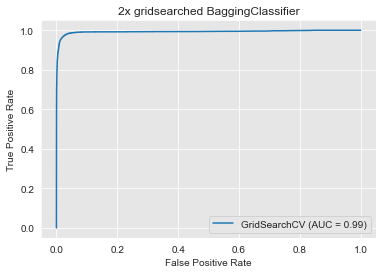

In [30]:
plot_roc_curve(second_bagged_grid,X_test,y_test)
plt.title('2x gridsearched BaggingClassifier')
plt.show()

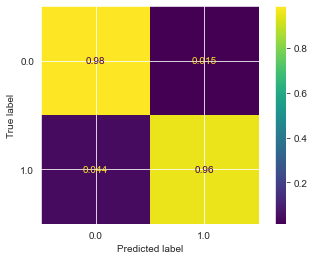

In [31]:
plot_confusion_matrix(second_bagged_grid,X_test,y_test,normalize='true')
plt.show()

## Random Forest

### Baseline RF

In [32]:
RFC = RandomForestClassifier(n_jobs=3)
RFC.fit(X_train,y_train)

rfc_pred = RFC.predict(X_test)
rfc_report = classification_report(y_test,rfc_pred,output_dict='true')
rfc_report = pd.DataFrame(rfc_report).iloc[:,0:3]
rfc_report

,0.0,1.0,accuracy
precision,0.989985,0.954035,0.983331
recall,0.989564,0.955824,0.983331
f1-score,0.989774,0.954929,0.983331
support,21177.000000,4799.000000,0.983331


### Tuning RF hyperparameters 
using the best_params_ from the decision tree model gridsearch_four

In [33]:
RFC_tuned = RandomForestClassifier(criterion='entropy',
                                    max_depth=125,
                                    max_features=20,
                                    max_leaf_nodes=750,
                                    min_samples_leaf=5,
                                    min_samples_split=2)
RFC_tuned.fit(X_train,y_train)

rfc_tuned_pred = RFC_tuned.predict(X_test)

rfc_tuned_report = classification_report(y_test,rfc_tuned_pred,output_dict='true')
rfc_tuned_report = pd.DataFrame(rfc_tuned_report).iloc[:,0:3]
rfc_tuned_report

,0.0,1.0,accuracy
precision,0.989164,0.943630,0.980674
recall,0.987109,0.952282,0.980674
f1-score,0.988135,0.947936,0.980674
support,21177.000000,4799.000000,0.980674


### Observations:
Random forest default settings consistently outperforms parameters used from best decision tree.  
Computational demands are too great to perform a gridsearch 

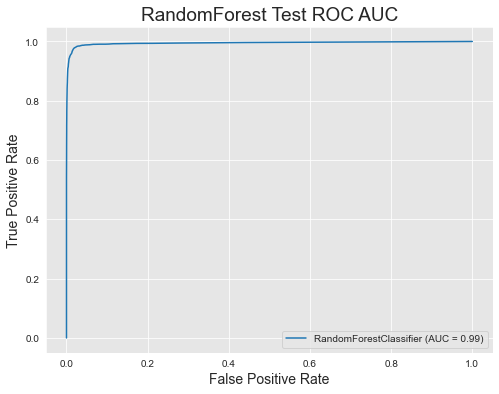

In [34]:
# baseline Random Forest ROC AUC
fig, ax = plt.subplots(figsize=(8, 6))
plot_roc_curve(RFC,X_test,y_test,ax=ax)
ax.set_title("RandomForest Test ROC AUC",fontsize=19)
ax.set_ylabel('True Positive Rate',fontsize=14)
ax.set_xlabel('False Positive Rate',fontsize=14)
plt.show()

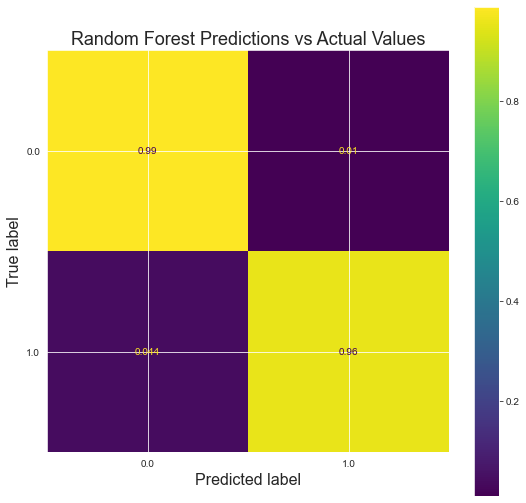

In [35]:
# baseline Random Forest confusion matrix
fig, ax = plt.subplots(figsize=(9, 9))
plot_confusion_matrix(RFC,X_test,y_test,normalize='true',ax=ax)
ax.set_title("Random Forest Predictions vs Actual Values",fontsize=18)
ax.set_ylabel('True label',fontsize=16)
ax.set_xlabel('Predicted label',fontsize=16)
plt.show()

# Iterative Performance Visualization

## F1 Score

In [43]:
f1_dict = {
        'baseline\nDecisionTree':grid_report.iloc[2,1],
        '4x gridsearched\nDecisionTree':grid_four_report.iloc[2,1],
        'baseline Bagging':tree_bagger_report.iloc[2,1],
        '2x gridsearched\nBagging':second_bagged_grid_report.iloc[2,1],
        'baseline\nRandomForest':rfc_report.iloc[2,1],
        'tuned\nRandomForest':rfc_tuned_report.iloc[2,1]
}
f1_dict = dict(sorted(f1_dict.items(), key=lambda item: item[1],reverse=True))

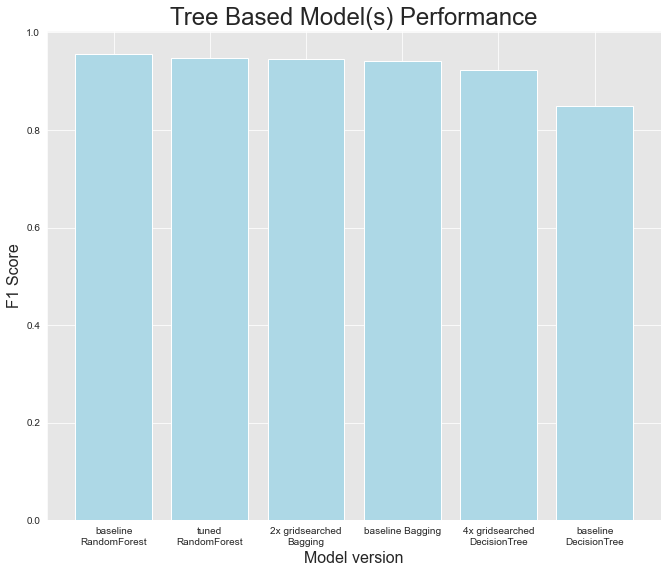

In [53]:
plt.figure(figsize=(11,9))

plt.bar(x=f1_dict.keys(),height=f1_dict.values(),color='lightblue')

plt.title('Tree Based Model(s) Performance',fontsize=24)
plt.ylabel('F1 Score',fontsize=16)
plt.xlabel('Model version',fontsize=16)
plt.show()

The difference is not massive, but the random forest with the default hyperparameters is the clear best performer, with an F1-score of 0.95. Precision and Recall (the basal components of F1) are also pretty good with both scoring 0.95+.  

## ROC AUC Curve

In [47]:
# calculate auc's
# first decision tree gridsearch 
base_gridsearch_fpr , base_gridsearch_tpr, base_gridsearch_thresholds = roc_curve(y_test, grid_pred)
base_gridsearch_auc = auc(base_gridsearch_fpr, base_gridsearch_tpr)

# best (fourth) decision tree gridsearch
gridsearch_four_fpr , gridsearch_four_tpr, gridsearch_four_thresholds = roc_curve(y_test, grid_four_pred)
gridsearch_four_auc = auc(gridsearch_four_fpr, gridsearch_four_tpr)

# baseline bagging 
base_bagging_fpr , base_bagging_tpr, base_bagging_thresholds = roc_curve(y_test, tree_bagger_pred)
base_bagging_auc = auc(base_bagging_fpr, base_bagging_tpr)

# second gridsearched bagging
second_grid_bagging_fpr , second_grid_bagging_tpr, second_grid_bagging_thresholds = roc_curve(y_test, second_bagged_grid_pred)
second_grid_bagging_auc = auc(second_grid_bagging_fpr, second_grid_bagging_tpr)

# baseline random forest
base_rfc_fpr , base_rfc_tpr, base_rfc_thresholds = roc_curve(y_test, rfc_pred)
base_rfc_auc = auc(base_rfc_fpr, base_rfc_tpr)

# tuned random forest
tuned_rfc_fpr , tuned_rfc_tpr, tuned_rfc_thresholds = roc_curve(y_test, rfc_tuned_pred)
tuned_rfc_auc = auc(tuned_rfc_fpr, tuned_rfc_tpr)

auc_list = [base_gridsearch_auc,gridsearch_four_auc,base_bagging_auc,second_grid_bagging_auc,base_rfc_auc,tuned_rfc_auc]

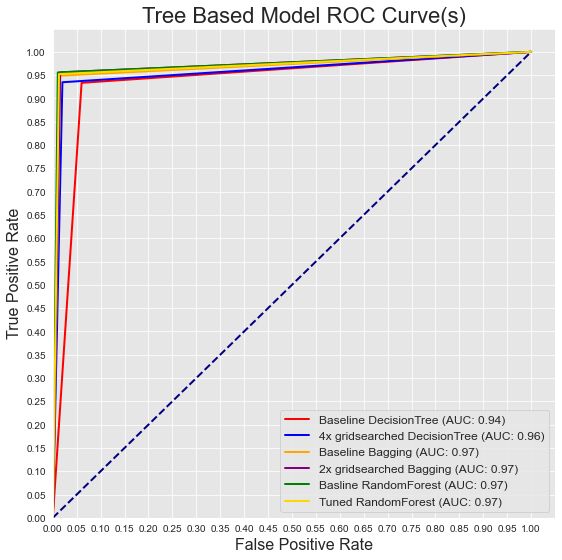

In [48]:
plt.figure(figsize=(9,9))
lw = 2

plt.plot(base_gridsearch_fpr, base_gridsearch_tpr, color='red',
         lw=lw, label=f'Baseline DecisionTree (AUC: {round(base_gridsearch_auc,2)})')
plt.plot(gridsearch_four_fpr, gridsearch_four_tpr, color='blue',
         lw=lw, label=f'4x gridsearched DecisionTree (AUC: {round(gridsearch_four_auc,2)})')
plt.plot(base_bagging_fpr,base_bagging_tpr, color='orange',
         lw=lw, label=f'Baseline Bagging (AUC: {round(base_bagging_auc,2)})')
plt.plot(second_grid_bagging_fpr,second_grid_bagging_tpr, color='purple',
         lw=lw, label=f'2x gridsearched Bagging (AUC: {round(second_grid_bagging_auc,2)})')        
plt.plot(base_rfc_fpr,base_rfc_tpr, color='green',
         lw=lw, label=f'Basline RandomForest (AUC: {round(base_rfc_auc,2)})')
plt.plot(tuned_rfc_fpr,tuned_rfc_tpr, color='gold',
         lw=lw, label=f'Tuned RandomForest (AUC: {round(tuned_rfc_auc,2)})')

# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title('Tree Based Model ROC Curve(s)',fontsize=22)
plt.legend(loc="lower right",prop={'size':12})

plt.show()

## True Positive rate

In [68]:
prediction_labels = ['Baseline\nDecisionTree',
                     '4x Gridsearched\nDecisionTree',
                     'Baseline Bagging',
                     '2x Gridsearched\nBagging',
                     'Baseline\nRandomForest',
                     'Tuned\nRandomForest']
predictions = [grid_pred,grid_four_pred,tree_bagger_pred,second_bagged_grid_pred,rfc_pred,rfc_tuned_pred]



tprs = []
fprs = []

tnrs = []
fnrs = []

for pred in predictions:
    matrix = confusion_matrix(y_test,pred,normalize='true')
    tprs.append(matrix[1][1])
    fprs.append(matrix[0][1])
    tnrs.append(matrix[0][0])
    fnrs.append(matrix[1][0])


<ipython-input-69-3fc35f12512d>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(prediction_labels,fontsize=12)


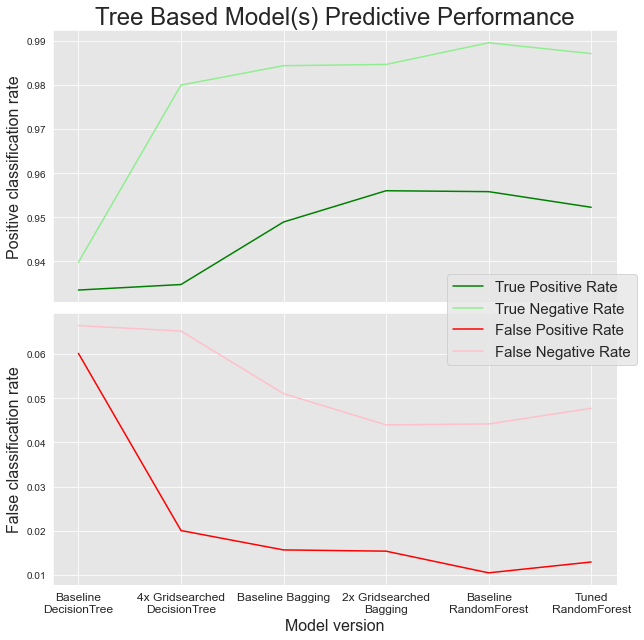

In [69]:
fig,(ax1,ax2) = plt.subplots(nrows=2,sharex=True)

# positive predictions
ax1.set_title("Tree Based Model(s) Predictive Performance",fontsize=24)

ax1.plot(range(0,6),tprs,color='green',label='True Positive Rate')
ax1.plot(range(0,6),tnrs,color='lightgreen',label='True Negative Rate')

ax1.set_ylabel("Positive classification rate",fontsize=16)

# negative predictions 
ax2.plot(range(0,6),fprs,color='red',label='False Positive Rate')
ax2.plot(prediction_labels,fnrs,color='pink',label='False Negative Rate')

ax2.set_ylabel("False classification rate",fontsize=16)
ax2.set_xlabel("Model version",fontsize=16)

ax2.set_xticklabels(prediction_labels,fontsize=12)

fig.set_size_inches(9, 9)
fig.tight_layout()
fig.legend(loc='center right',prop={'size':15})
plt.show()

# Final Model Interpretation and Evaluation

## Plot Random Forest Feature Importance

In [80]:
# zip feature labels and importances into a dict
feature_importance_dict = {t[0]:t[1] for t in list(zip(X_train.columns.values,RFC.feature_importances_))}
# sort the dict by value
feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1],reverse=True))

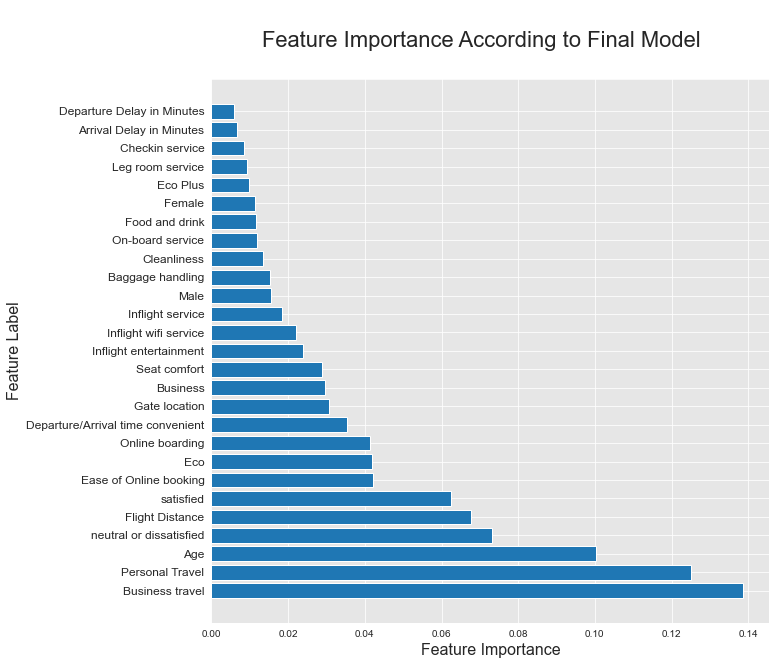

In [85]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,10))
    plt.barh(range(len(feature_importance_dict.keys())), list(feature_importance_dict.values()), align='center') 
    plt.yticks(np.arange(n_features),list(feature_importance_dict.keys()),fontsize=12) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(RFC)
plt.suptitle("\nFeature Importance According to Final Model",fontsize=22)
plt.xlabel('Feature Importance',fontsize=16)
plt.ylabel('Feature Label',fontsize=16)
plt.show()

### Concatenate Train and Test Samples for Analysis

In [97]:
y_vert = pd.Series(y_test)
y_vert

0        0.0
1        0.0
2        1.0
3        0.0
4        0.0
        ... 
25971    1.0
25972    0.0
25973    0.0
25974    0.0
25975    0.0
Length: 25976, dtype: float64

In [91]:
y_test

array([0., 0., 1., ..., 0., 0., 0.])

In [102]:
# concat X and y, train and test samples into a single df for descriptive analysis.
X_evaluate = pd.concat([X_train,X_test])

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_evaluate = pd.concat([y_train,y_test])

eval_df = pd.concat([y_evaluate,X_evaluate],axis=1)
eval_df.rename(columns = {0:'disloyal Customer'}, inplace=True)

eval_df.head()

,disloyal Customer,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Arrival Delay in Minutes,Female,Male,Business travel,Personal Travel,Business,Eco,Eco Plus,neutral or dissatisfied,satisfied
0,0.0,13,460,3,4,3,1,5,3,5,...,18.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,25,235,3,2,3,3,1,3,1,...,6.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,26,1142,2,2,2,2,5,5,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,25,562,2,5,5,5,2,2,2,...,9.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,61,214,3,3,3,3,4,5,5,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


### Age vs. Flight Distance by Customer Loyalty

c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


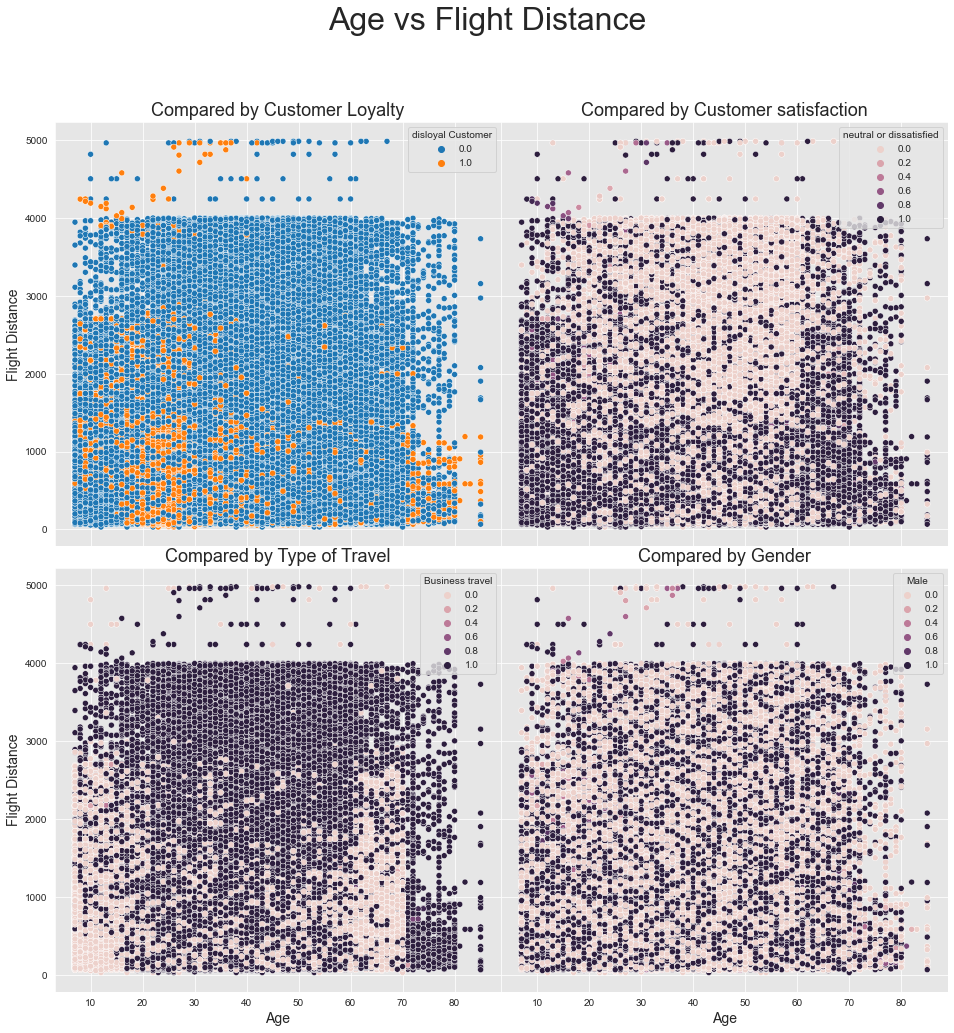

In [105]:
fig,axs = plt.subplots(2,2,figsize=(16,16),sharex=True,sharey=True)

loy = sns.scatterplot(x=eval_df.Age,y=eval_df['Flight Distance'],hue=eval_df['disloyal Customer'],ax=axs[0,0])
axs[0,0].set_title('Compared by Customer Loyalty',fontsize=18)
axs[0,0].set_ylabel('Flight Distance',fontsize=14)
axs[0,0].set_xlabel('Age',fontsize=14)

sat = sns.scatterplot(x=eval_df.Age,y=eval_df['Flight Distance'],hue=eval_df['neutral or dissatisfied'],ax=axs[0,1])
axs[0,1].set_title('Compared by Customer satisfaction',fontsize=18)
axs[0,1].set_ylabel('Flight Distance',fontsize=14)
axs[0,1].set_xlabel('Age',fontsize=14)

bix = sns.scatterplot(x=eval_df.Age,y=eval_df['Flight Distance'],hue=eval_df['Business travel'],ax=axs[1,0])
axs[1,0].set_title('Compared by Type of Travel',fontsize=18)
axs[1,0].set_ylabel('Flight Distance',fontsize=14)
axs[1,0].set_xlabel('Age',fontsize=14)

gen = sns.scatterplot(x=eval_df.Age,y=eval_df['Flight Distance'],hue=eval_df['Male'],ax=axs[1,1])
axs[1,1].set_title('Compared by Gender',fontsize=18)
axs[1,1].set_ylabel('Flight Distance',fontsize=14)
axs[1,1].set_xlabel('Age',fontsize=14)


fig.suptitle('Age vs Flight Distance',fontsize=32)
plt.subplots_adjust(wspace=.001,hspace=.05)
plt.show()

The above plot isn't incredibly telling in and of itself, however there are some noteable clusters. Its obvious that loyal customers tend to be more satisfied, but the focus of this analysis is to discover what is stopping disloyal customer from becoming loyal. With that in mind, there is a cluster of 16-39 year old, flying less than 300 miles, that are mostly disloyal but relatively even between satisfied and disatisfeid. It also appears that 70+ year olds are more likely to be satisfied if they fly more than 1500 miles, while most of the disloyal customers in this age group fly less than 1500 miles. It also appears that business travel accoutns for a significant portion of the aformentioned age groups. 

### Survey Responses Based on Age, Flight Distance, Purpose for Travel

In [106]:
# inspect disloyal customers between 15 and 40, for flights less than 3000 miles.
disloyal_youth_df = eval_df.loc[(eval_df['Age']<40)&(eval_df['Age']>15)&(eval_df['disloyal Customer']==1)&(eval_df['Flight Distance']<3000)]

disloyal_youth_survey_dict ={}
for col in disloyal_youth_df.iloc[:,3:17].columns:
    disloyal_youth_survey_dict[col]=disloyal_youth_df[col].sum()

youth_colors = []
for val in disloyal_youth_survey_dict.values():
    if val <195000:
        youth_colors.append('orangered')
    elif val > 210000:
        youth_colors.append('mediumseagreen')
    else:
        youth_colors.append('gold')


In [107]:
# Inspect Disloyal Senior (70+) Customers, for flights less than 1500 miles
disloyal_seniors_df = eval_df.loc[(eval_df['Age']>70)&(eval_df['disloyal Customer']==1)&(eval_df['Flight Distance']<1500)]

disloyal_seniors_survey_dict ={}
for col in disloyal_seniors_df.iloc[:,3:17].columns:
    disloyal_seniors_survey_dict[col]=disloyal_seniors_df[col].sum()
    
seniors_colors = []
for val in disloyal_seniors_survey_dict.values():
    if val <840:
        seniors_colors.append('orangered')
    elif val > 930:
        seniors_colors.append('mediumseagreen')
    else:
        seniors_colors.append('gold')

In [115]:
# Inspect Disloyal business travel, all distances
disloyal_business_df = eval_df.loc[(eval_df['Business travel']==0)&(eval_df['disloyal Customer']==1)]

disloyal_business_survey_dict = {}
for col in disloyal_business_df.iloc[:,3:17].columns:
    disloyal_business_survey_dict[col] = disloyal_business_df[col].sum()

disloyal_business_colors = []
for val in disloyal_business_survey_dict.values():
    if val <= np.quantile(list(disloyal_business_survey_dict.values()),0.25):
        disloyal_business_colors.append('orangered')
    elif val >= np.quantile(list(disloyal_business_survey_dict.values()),0.75):
        disloyal_business_colors.append('mediumseagreen')
    else:
        disloyal_business_colors.append('gold')

<ipython-input-116-573ec48e6e41>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([0,50000,100000,150000,200000,250000],fontsize=16)
<ipython-input-116-573ec48e6e41>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([0,200,400,600,800,1000],fontsize=18)
<ipython-input-116-573ec48e6e41>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(x_labels,fontsize=20)
<ipython-input-116-573ec48e6e41>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels([0,50000,100000,150000,200000,250000,300000],fontsize=18)
<ipython-input-116-573ec48e6e41>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(x_labels,fontsize=20)


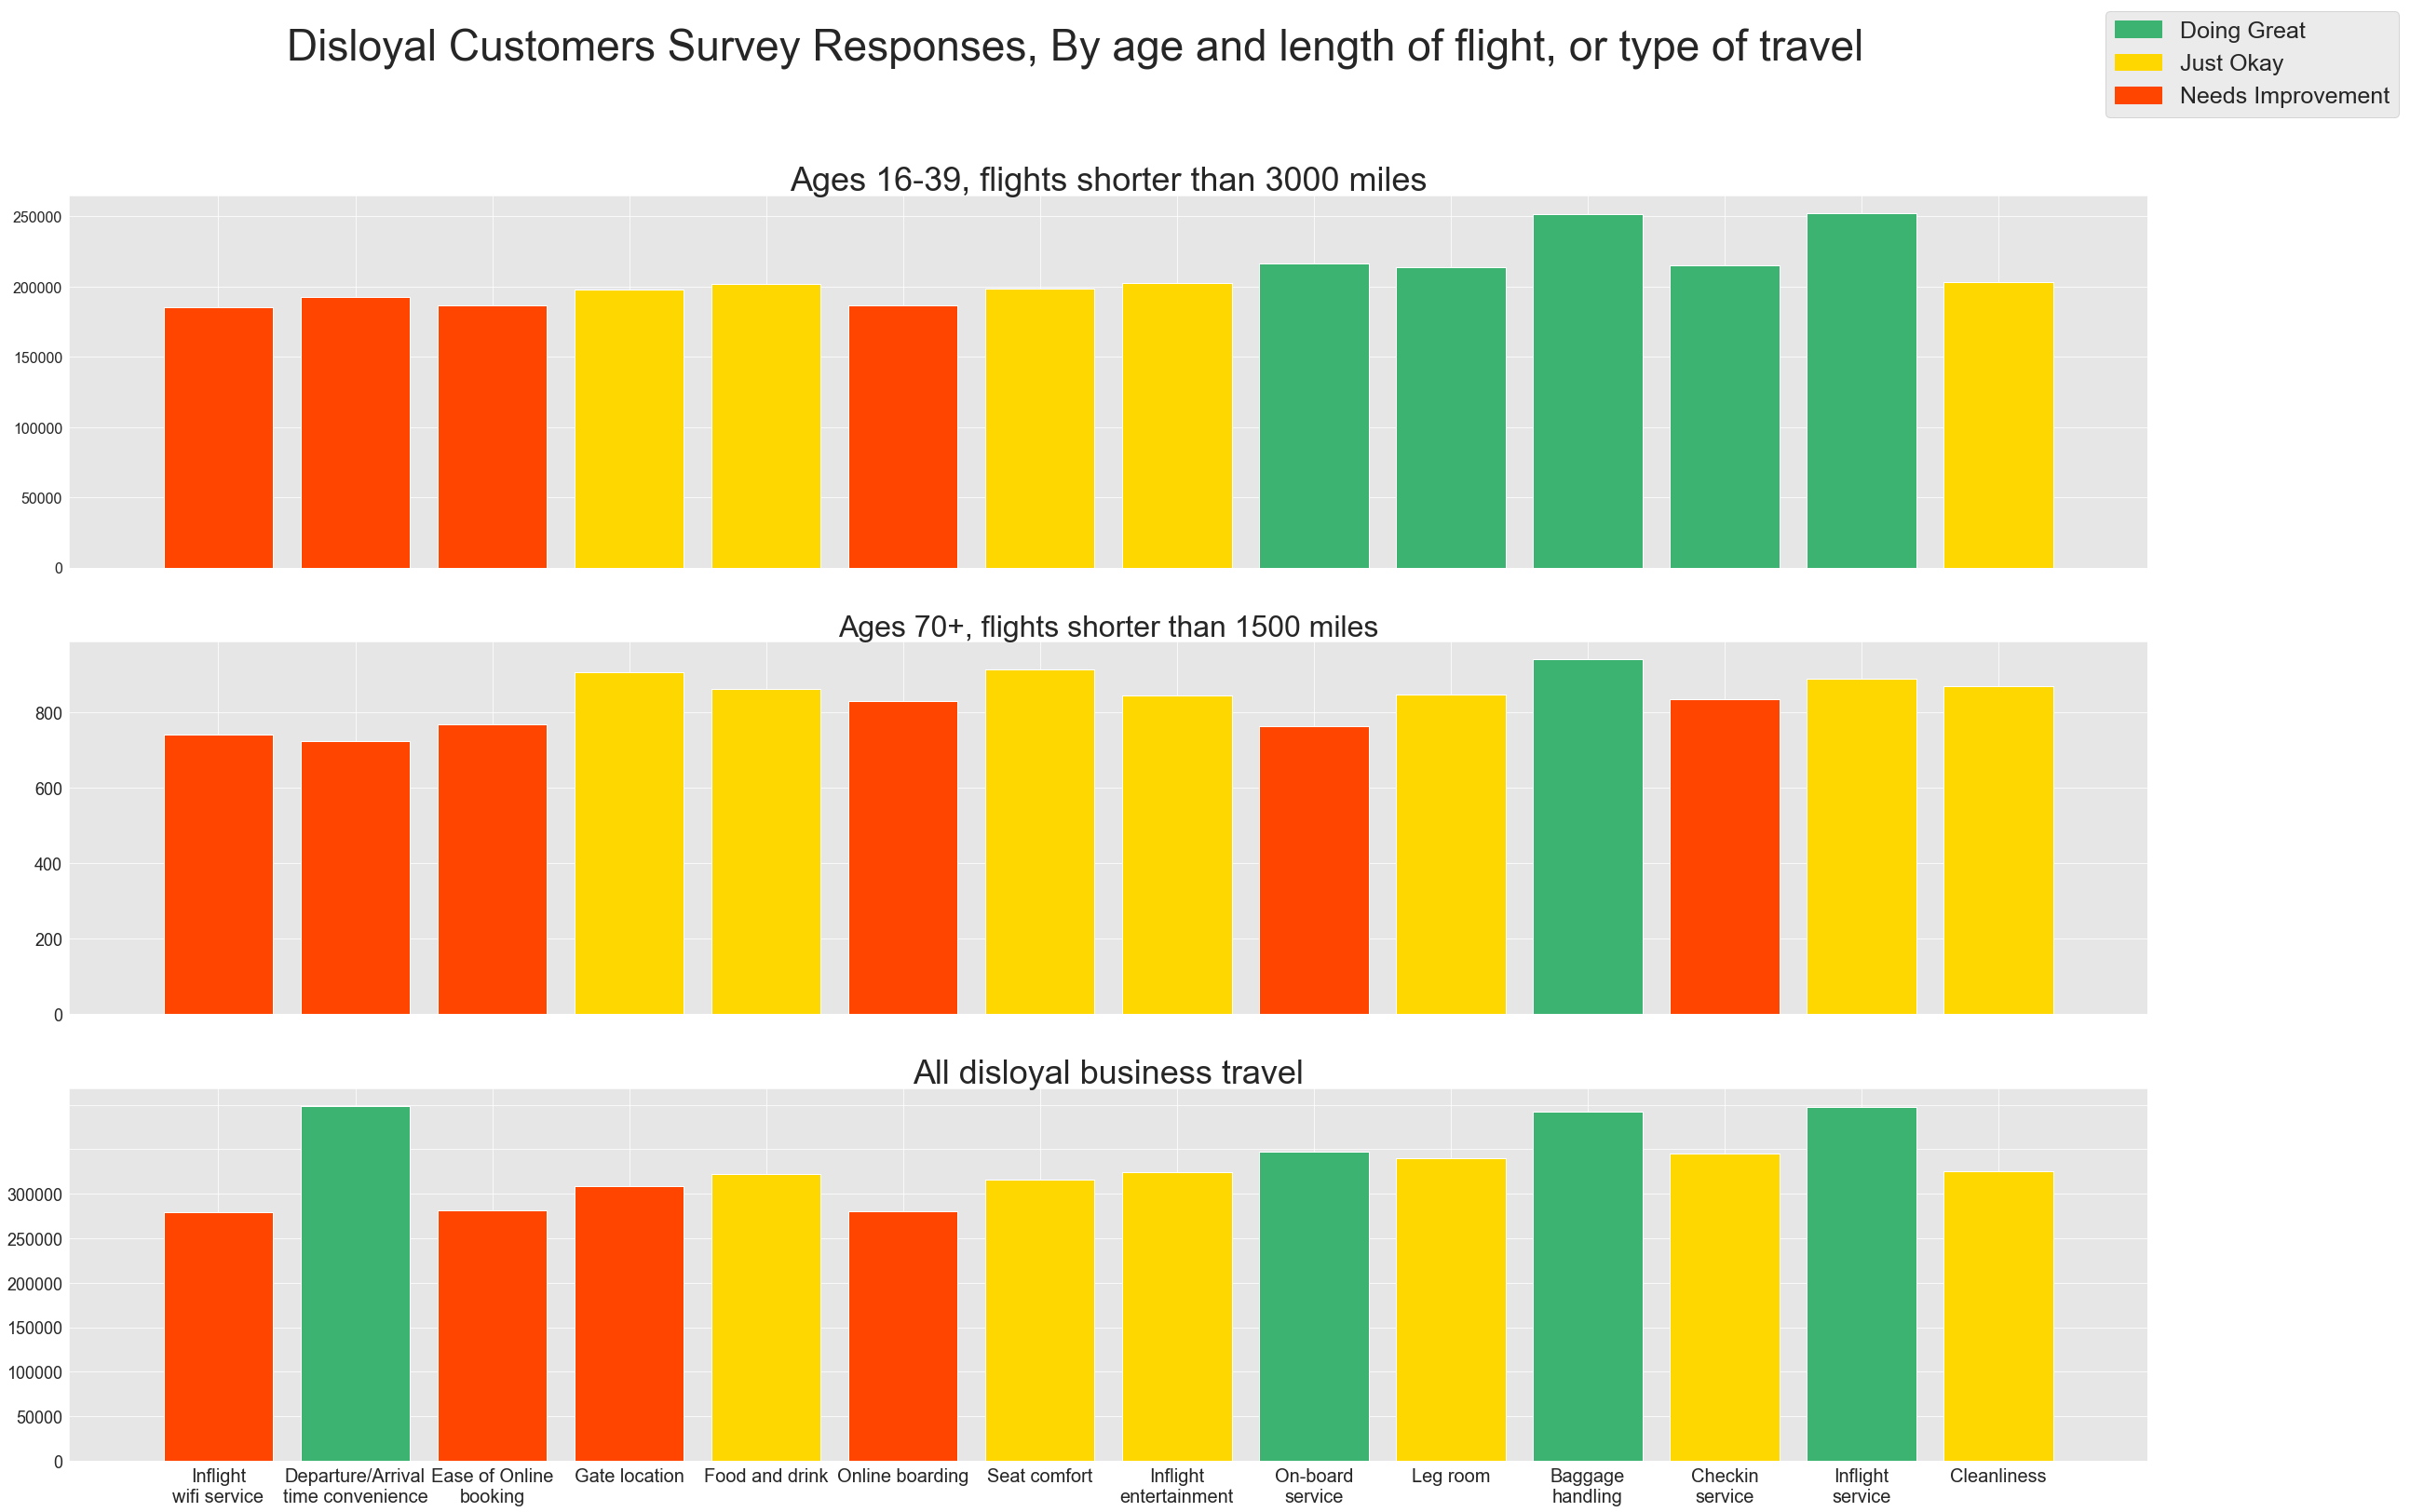

In [116]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

red_patch = mpatches.Patch(color='orangered', label='Needs Improvement')
yellow_patch = mpatches.Patch(color='gold', label='Just Okay')
green_patch = mpatches.Patch(color='mediumseagreen',label='Doing Great')

x_labels = ['Inflight\nwifi service', 
'Departure/Arrival\ntime convenience', 
'Ease of Online\nbooking', 
'Gate location', 
'Food and drink',
'Online boarding', 
'Seat comfort', 
'Inflight\nentertainment', 
'On-board\nservice', 
'Leg room', 
'Baggage\nhandling', 
'Checkin\nservice', 
'Inflight\nservice', 
'Cleanliness']

fig,axs = plt.subplots(3,1,figsize=(40,25),sharex=True)

axs[0].bar(x=list(disloyal_youth_survey_dict.keys()),height=list(disloyal_youth_survey_dict.values()),color=youth_colors)
axs[0].set_yticklabels([0,50000,100000,150000,200000,250000],fontsize=16)
axs[0].set_title('Ages 16-39, flights shorter than 3000 miles',fontsize=36)


axs[1].bar(x=list(disloyal_seniors_survey_dict.keys()),height=list(disloyal_seniors_survey_dict.values()),color=seniors_colors)
axs[1].set_yticklabels([0,200,400,600,800,1000],fontsize=18)
axs[1].set_xticklabels(x_labels,fontsize=20)
axs[1].set_title("Ages 70+, flights shorter than 1500 miles",fontsize=32)

axs[2].bar(x=list(disloyal_business_survey_dict.keys()),height=list(disloyal_business_survey_dict.values()),color=disloyal_business_colors)
axs[2].set_yticklabels([0,50000,100000,150000,200000,250000,300000],fontsize=18)
axs[2].set_xticklabels(x_labels,fontsize=20)
axs[2].set_title("All disloyal business travel",fontsize=36)


fig.legend(handles=[green_patch,yellow_patch,red_patch],prop={'size':25},loc='upper right')
fig.suptitle("Disloyal Customers Survey Responses, By age and length of flight, or type of travel",fontsize=46)
plt.show()

Across both age groups as well as for all business travel, Inflight wifi, departure/arrival time convenience and ease of online booking all scored in the bottom quartile of overall customer satisfaction. Food and drink, and cleanliness are just average for accross the board. Baggage hadnlign and Inflight wifi score in the fourth quartile accross the board. 

 Online boarding, one of the top 5 most important features to the model, is in the bottom quartile for young adults as well as businss travel, and only about average for seniors. Businss travel and young adults are well pleased with the check-in service but it is highly disliked by seniors. Gate Location is just okay for businss travelers and young adults, but seniors are highly satisfied here. 

 Based on this graph I would recommend focusing on improving the online experience (boarding and booking) for young adults and businss travelers, and improve inflight wifi, food and drink, seat comfort, and overall cleanliness. Departure/Arrival times and gate locations would probably have significant impact if improved but it is likely impossible to improve these things strictly internally.

### Market Share by Age and Purpose for Travel

In [125]:
eval_df['Business travel'].loc[eval_df['Business travel']==1].sum()

154634.0

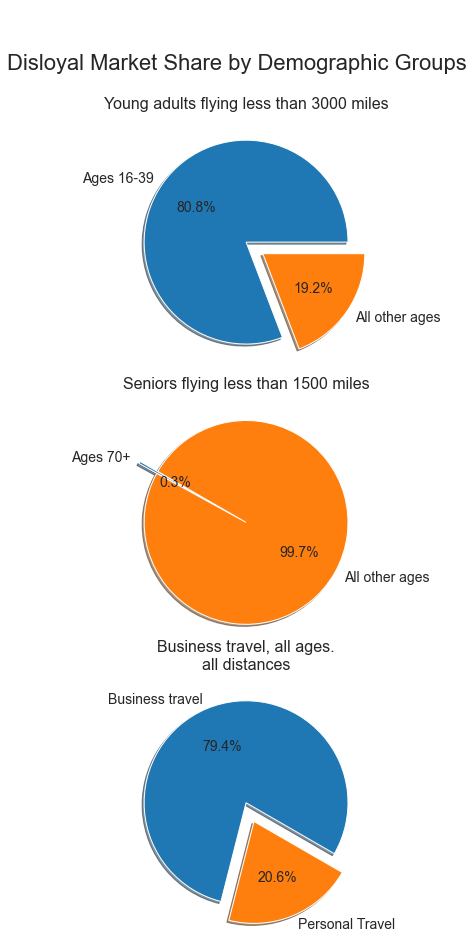

In [126]:
fig,axs = plt.subplots(3,1,figsize=(10,15))
axs[0].pie([len(disloyal_youth_df),(len(eval_df.loc[eval_df['disloyal Customer']==1])-len(disloyal_youth_df))],
        labels=['Ages 16-39','All other ages'],
        startangle=0,
        shadow=True,
        explode=[0,0.2],
        autopct='%1.1f%%',
        textprops={'fontsize':14})
axs[0].set_title("Young adults flying less than 3000 miles",fontsize=16)


axs[1].pie([len(disloyal_seniors_df),(len(eval_df.loc[eval_df['disloyal Customer']==1])-len(disloyal_seniors_df))],
        labels=['Ages 70+','All other ages'],
        startangle=150,
        shadow=True,
        explode=[.2,0],
        autopct='%1.1f%%',
        textprops={'fontsize':14})
axs[1].set_title("Seniors flying less than 1500 miles",fontsize=16)

axs[2].pie([eval_df['Business travel'].loc[eval_df['Business travel']==1].sum(),eval_df['Personal Travel'].loc[eval_df['Personal Travel']==1].sum()],
        labels=['Business travel','Personal Travel'],
        startangle=-30,
        shadow=True,
        explode=[0,0.2],
        autopct='%1.1f%%',
        textprops={'fontsize':14})
axs[2].set_title("Business travel, all ages.\nall distances",fontsize=16)

fig.suptitle("\n\nDisloyal Market Share by Demographic Groups",fontsize=22)
plt.subplots_adjust(hspace=0.1)
plt.show()

Examination of the market share of each of group shows that improving satisfaction for senior customers would probably have a significant impact on overall business performance. Based on the above figure it is clearly best to focus on improving the customer experience for business traveler's and young adults, obviously there is likely much overlap between these two groups. 

### Survey Responses by Customer Loyalty and Satisfaction

In [131]:
# sum of survey responses for disloyal satisfied customers
disloyal_survey_satisfied = {}
for col in eval_df.iloc[:,3:17].columns:
    disloyal_survey_satisfied[col] = eval_df.loc[(eval_df['disloyal Customer']==1)&(eval_df['satisfied']==1)][col].sum()

disloyal_satisfied_colors = []
for val in disloyal_survey_satisfied.values():
    if val < np.quantile(list(disloyal_survey_satisfied.values()),0.25):
        disloyal_satisfied_colors.append('orangered')
    elif val > np.quantile(list(disloyal_survey_satisfied.values()),0.75):
        disloyal_satisfied_colors.append('mediumseagreen')
    else:
        disloyal_satisfied_colors.append('gold')

# sum of survey responses for disloyal disatisfied customers
disloyal_survey_disatisfied = {}
for col in eval_df.iloc[:,3:17].columns:
    disloyal_survey_disatisfied[col] = eval_df.loc[(eval_df['disloyal Customer']==1)&(eval_df['satisfied']==0)][col].sum()

disloyal_disatisfied_colors = []
for val in disloyal_survey_satisfied.values():
    if val < np.quantile(list(disloyal_survey_disatisfied.values()),0.25):
        disloyal_disatisfied_colors.append('orangered')
    elif val > np.quantile(list(disloyal_survey_disatisfied.values()),0.75):
        disloyal_disatisfied_colors.append('mediumseagreen')
    else:
        disloyal_disatisfied_colors.append('gold')

########################################################

# sum of survey responses for loyal satisfied customers
loyal_survey_satisfied = {}
for col in eval_df.iloc[:,3:17].columns:
    loyal_survey_satisfied[col] = eval_df.loc[(eval_df['disloyal Customer']==0)&(eval_df['satisfied']==1)][col].sum()

loyal_satisfied_colors = []
for val in loyal_survey_satisfied.values():
    if val < np.quantile(list(loyal_survey_satisfied.values()),0.25):
        loyal_satisfied_colors.append('orangered')
    elif val > np.quantile(list(loyal_survey_satisfied.values()),0.75):
        loyal_satisfied_colors.append('mediumseagreen')
    else:
        loyal_satisfied_colors.append('gold')

# sum of survey responses for loyal disatisfied customers
loyal_survey_disatisfied = {}
for col in eval_df.iloc[:,3:17].columns:
    loyal_survey_disatisfied[col] = eval_df.loc[(eval_df['disloyal Customer']==0)&(eval_df['satisfied']==0)][col].sum()

loyal_disatisfied_colors = []
for val in loyal_survey_disatisfied.values():
    if val < np.quantile(list(loyal_survey_disatisfied.values()),0.25):
        loyal_disatisfied_colors.append('orangered')
    elif val > np.quantile(list(loyal_survey_disatisfied.values()),0.75):
        loyal_disatisfied_colors.append('mediumseagreen')
    else:
        loyal_disatisfied_colors.append('gold')

<ipython-input-133-8d324d897e82>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([0,50000,100000,150000,200000,250000],fontsize=18)


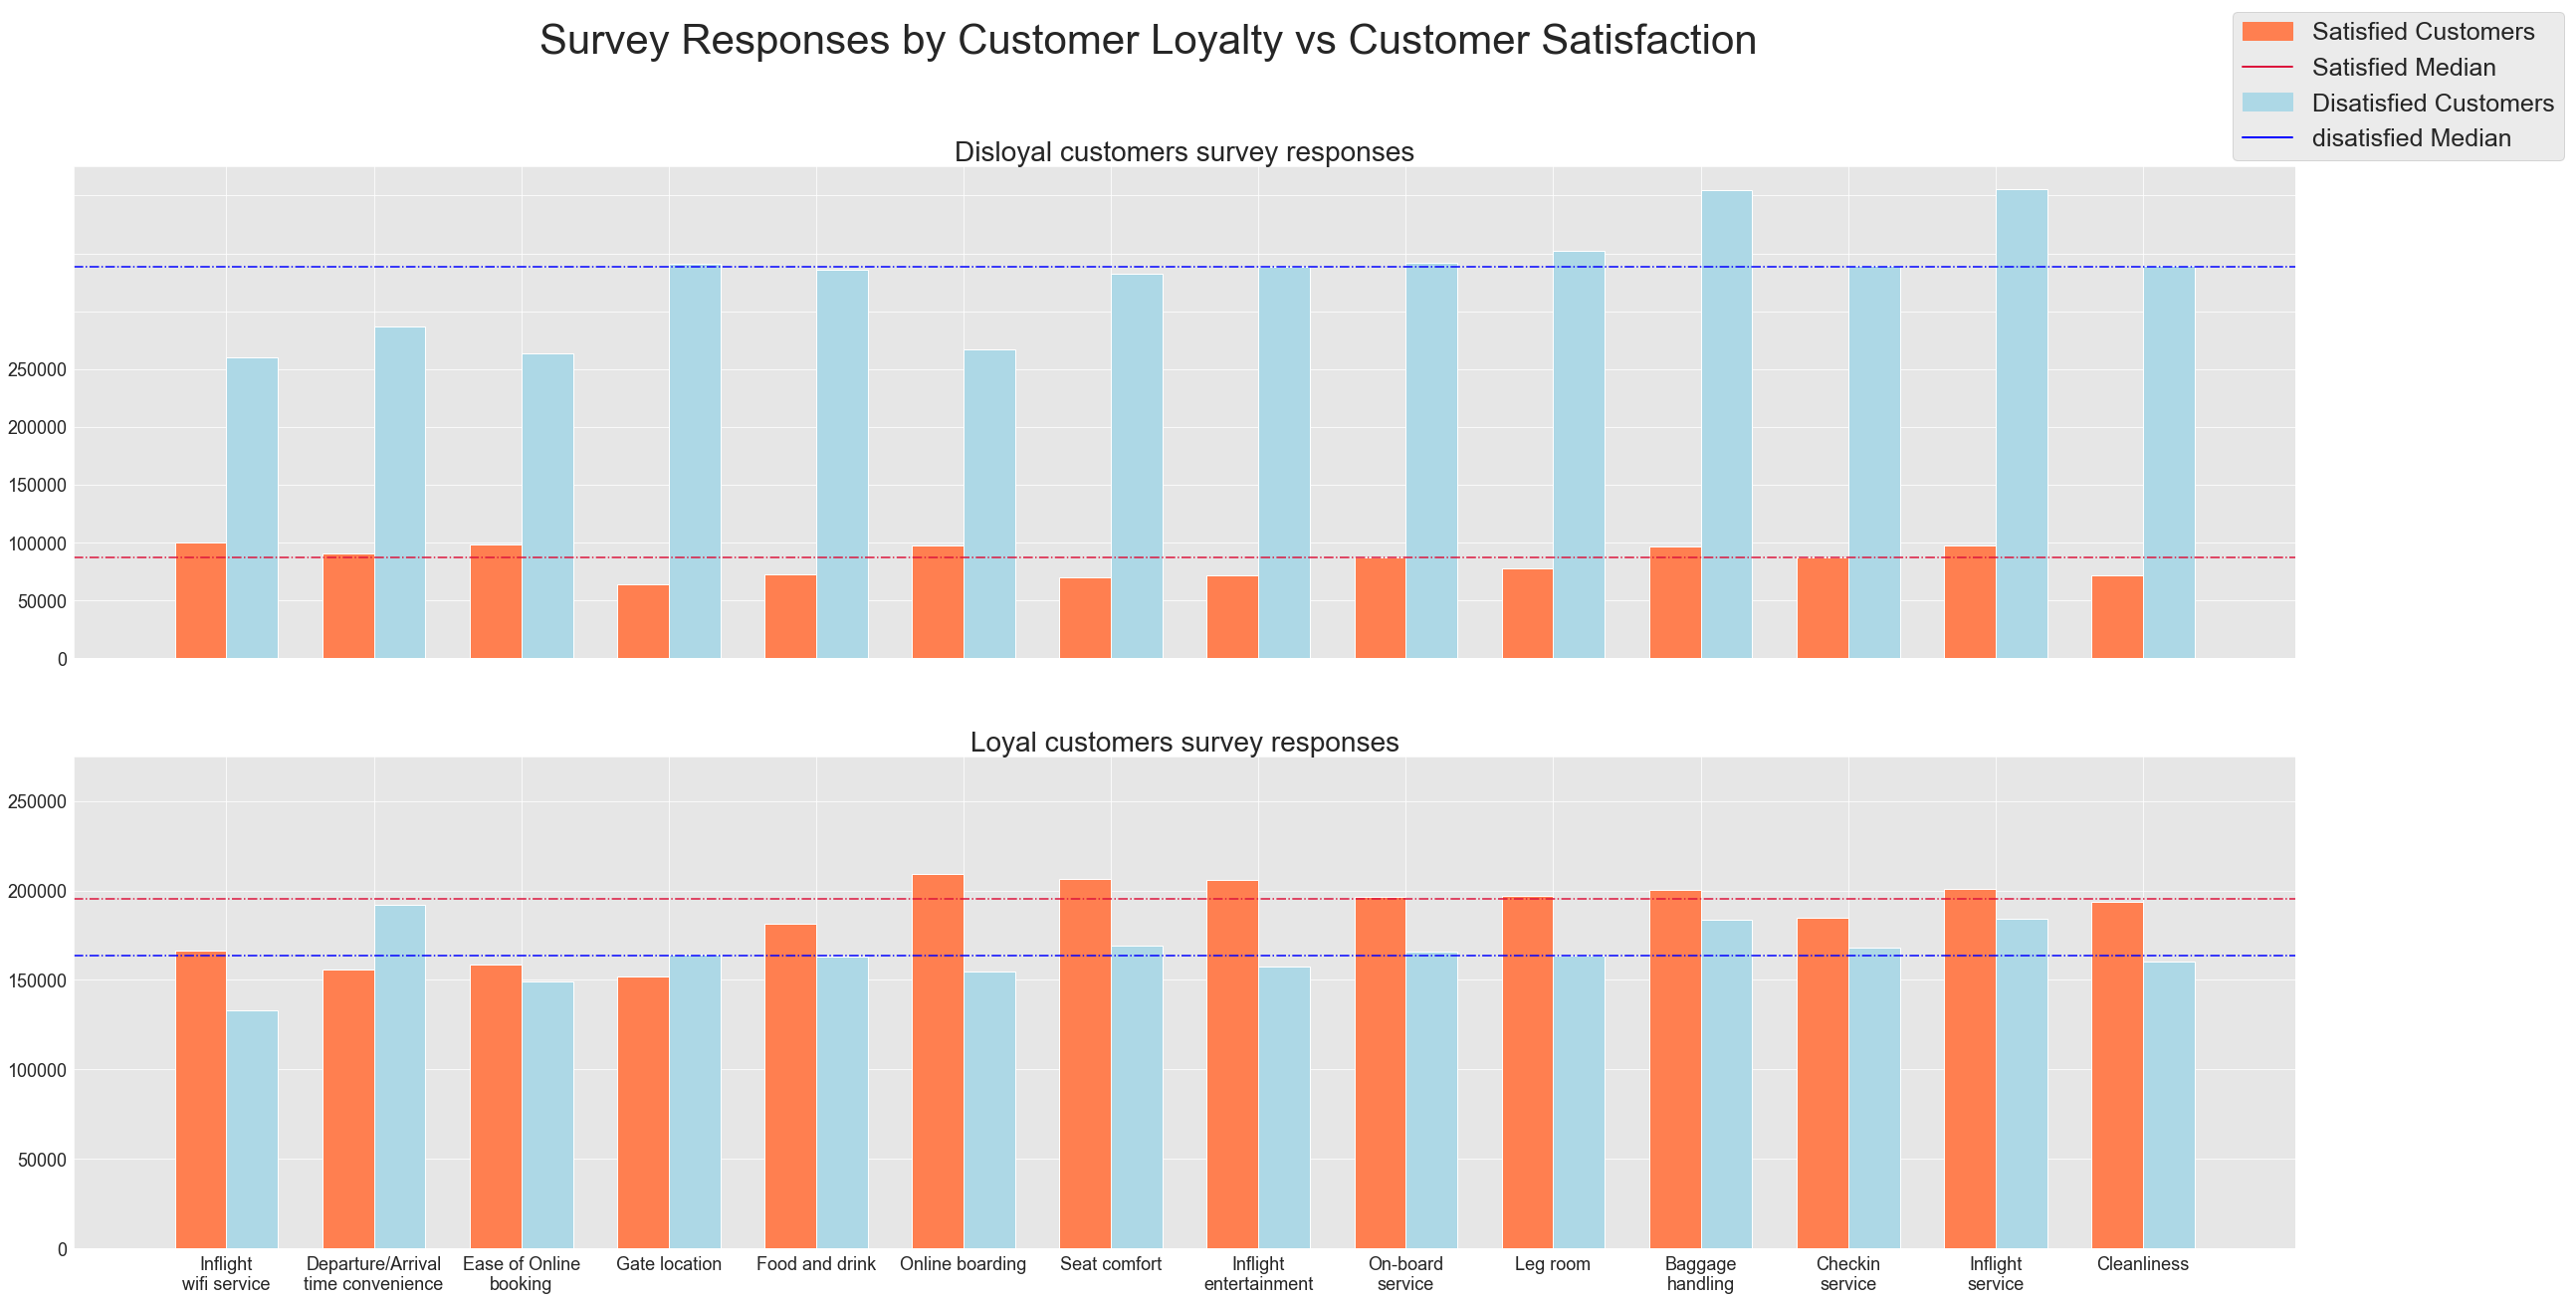

In [133]:
satisfied_patch = mpatches.Patch(color='coral', label='Satisfied Customers')
disatisfied_patch = mpatches.Patch(color='lightblue', label='Disatisfied Customers')
satisfied_median = Line2D([0],[0],color='crimson',lw=2,label='Satisfied Median')
disatisfied_median = Line2D([0],[0],color='blue',lw=2,label='disatisfied Median')

width = .35

x_labels = ['Inflight\nwifi service', 
'Departure/Arrival\ntime convenience', 
'Ease of Online\nbooking', 
'Gate location', 
'Food and drink',
'Online boarding', 
'Seat comfort', 
'Inflight\nentertainment', 
'On-board\nservice', 
'Leg room', 
'Baggage\nhandling', 
'Checkin\nservice', 
'Inflight\nservice', 
'Cleanliness']

x = np.arange(len(x_labels))

fig,axs = plt.subplots(2,1,figsize=(40,20),sharex=True)

axs[0].bar(x= x + width/2,height=list(disloyal_survey_disatisfied.values()),width=width,label='disatisfied',color='lightblue')
axs[0].axhline(np.quantile(list(disloyal_survey_disatisfied.values()),0.5),color='blue',linestyle='-.')

axs[0].bar(x= x - width/2,height=list(disloyal_survey_satisfied.values()),width=width,label='satisfied',color='coral')
axs[0].axhline(np.quantile(list(disloyal_survey_satisfied.values()),0.5),color='crimson',linestyle='-.')

axs[0].set_title('Disloyal customers survey responses',fontsize=28)
axs[0].set_yticklabels([0,50000,100000,150000,200000,250000],fontsize=18)



axs[1].bar(x= x - width/2,height=list(loyal_survey_satisfied.values()),width=width,label='satisfied',color='coral')
axs[1].axhline(np.quantile(list(loyal_survey_satisfied.values()),0.5),color='crimson',linestyle='-.')

axs[1].bar(x= x + width/2,height=list(loyal_survey_disatisfied.values()),width=width,label='disatisfied',color='lightblue')
axs[1].axhline(np.quantile(list(loyal_survey_disatisfied.values()),0.5),color='blue',linestyle='-.')

axs[1].set_title('Loyal customers survey responses',fontsize=28)
axs[1].set_ylim(0,275000)
plt.xticks(x,x_labels,fontsize=18)
plt.yticks(fontsize=18)


fig.legend(handles=[satisfied_patch,satisfied_median,disatisfied_patch,disatisfied_median],prop={'size':25})
fig.suptitle("Survey Responses by Customer Loyalty vs Customer Satisfaction",fontsize=42)
plt.show()

As one would expect disloyal customers tend to be more disatisfied. Unlike they're loyal counter parts, disloyal customers are displeased the most with checkin service and inflight service. They are also more displeased than usual with on-board service, leg room, check-in service, and cleanliness. 

Based on this figure with consideration to feature importance of the predictive model, I recommend focusing on improving services involved with the check-in and boarding process as well as the in-flight experience; esepcially in-flight entertainment, online boarding, and seat comfort. 

### Age and Flight Distance by Customer Loyalty and Satisfaction

In [134]:
# bar heights for loyal satisfied customers
loyal_satisfied_flight_distance = eval_df['Flight Distance'].loc[(eval_df['satisfied']==1)&(eval_df['disloyal Customer']==0)]
loyal_satisfied_flight_ranges = pd.cut(loyal_satisfied_flight_distance,bins=40).value_counts().index

loyal_satisfied_flight_heights = []
for interval in loyal_satisfied_flight_ranges:
    chunk = sum((loyal_satisfied_flight_distance>interval.left)&(loyal_satisfied_flight_distance<=interval.right))
    loyal_satisfied_flight_heights.append(chunk)

# bar heights for loyal but disatisfied customers
loyal_disatisfied_flight_distance = eval_df['Flight Distance'].loc[(eval_df['satisfied']==0)&(eval_df['disloyal Customer']==0)]
loyal_disatisfied_flight_ranges = pd.cut(loyal_disatisfied_flight_distance,bins=40).value_counts().index

loyal_disatisfied_flight_heights = []
for interval in loyal_disatisfied_flight_ranges:
    chunk = sum((loyal_disatisfied_flight_distance>interval.left)&(loyal_disatisfied_flight_distance<=interval.right))
    loyal_disatisfied_flight_heights.append(chunk)
    
# bar heights for disloyal but satisfied customers
disloyal_satisfied_flight_distance = eval_df['Flight Distance'].loc[(eval_df['satisfied']==1)&(eval_df['disloyal Customer']==1)]
disloyal_satisfied_flight_ranges = pd.cut(disloyal_satisfied_flight_distance,bins=40).value_counts().index

disloyal_satisfied_flight_heights = []
for interval in disloyal_satisfied_flight_ranges:
    chunk = sum((disloyal_satisfied_flight_distance>interval.left)&(disloyal_satisfied_flight_distance<=interval.right))
    disloyal_satisfied_flight_heights.append(chunk)
disloyal_satisfied_flight_heights = [-x for x in disloyal_satisfied_flight_heights]

# bar heights for disloyal and disatisfied customers
disloyal_disatisfied_flight_distance = eval_df['Flight Distance'].loc[(eval_df['satisfied']==0)&(eval_df['disloyal Customer']==1)]
disloyal_disatisfied_flight_ranges = pd.cut(disloyal_disatisfied_flight_distance,bins=40).value_counts().index

disloyal_disatisfied_flight_heights = []
for interval in disloyal_disatisfied_flight_ranges:
    chunk = sum((disloyal_disatisfied_flight_distance>interval.left)&(disloyal_disatisfied_flight_distance<=interval.right))
    disloyal_disatisfied_flight_heights.append(chunk)
disloyal_disatisfied_flight_heights = [-x for x in disloyal_disatisfied_flight_heights]

In [135]:
# bar heights for loyal satisfied customers
loyal_satisfied_age = eval_df['Age'].loc[(eval_df['satisfied']==1)&(eval_df['disloyal Customer']==0)]
loyal_satisfied_age_ranges = pd.cut(loyal_satisfied_age,bins=50).value_counts().index

loyal_satisfied_age_heights = []
for interval in loyal_satisfied_age_ranges:
    chunk = sum((loyal_satisfied_age>interval.left)&(loyal_satisfied_age<=interval.right))
    loyal_satisfied_age_heights.append(chunk)

# bar heights for loyal but disatisfied customers
loyal_disatisfied_age = eval_df['Age'].loc[(eval_df['satisfied']==0)&(eval_df['disloyal Customer']==0)]
loyal_disatisfied_age_ranges = pd.cut(loyal_disatisfied_age,bins=50).value_counts().index

loyal_disatisfied_age_heights = []
for interval in loyal_disatisfied_age_ranges:
    chunk = sum((loyal_disatisfied_age>interval.left)&(loyal_disatisfied_age<=interval.right))
    loyal_disatisfied_age_heights.append(chunk)
    
# bar heights for disloyal but satisfied customers
disloyal_satisfied_age = eval_df['Age'].loc[(eval_df['satisfied']==1)&(eval_df['disloyal Customer']==1)]
disloyal_satisfied_age_ranges = pd.cut(disloyal_satisfied_age,bins=50).value_counts().index

disloyal_satisfied_age_heights = []
for interval in disloyal_satisfied_age_ranges:
    chunk = sum((disloyal_satisfied_age>interval.left)&(disloyal_satisfied_age<=interval.right))
    disloyal_satisfied_age_heights.append(chunk)
disloyal_satisfied_age_heights = [-x for x in disloyal_satisfied_age_heights]

# bar heights for disloyal and disatisfied customers
disloyal_disatisfied_age = eval_df['Age'].loc[(eval_df['satisfied']==0)&(eval_df['disloyal Customer']==1)]
disloyal_disatisfied_age_ranges = pd.cut(disloyal_disatisfied_age,bins=50).value_counts().index

disloyal_disatisfied_age_heights = []
for interval in disloyal_disatisfied_age_ranges:
    chunk = sum((disloyal_disatisfied_age>interval.left)&(disloyal_disatisfied_age<=interval.right))
    disloyal_disatisfied_age_heights.append(chunk)
disloyal_disatisfied_age_heights = [-x for x in disloyal_disatisfied_age_heights]

In [136]:
flight_x_ticks = np.linspace(min(eval_df['Flight Distance']),max(eval_df['Flight Distance']),num=40)
age_x_ticks = np.linspace(min(eval_df['Age']),max(eval_df['Age']),num=50)

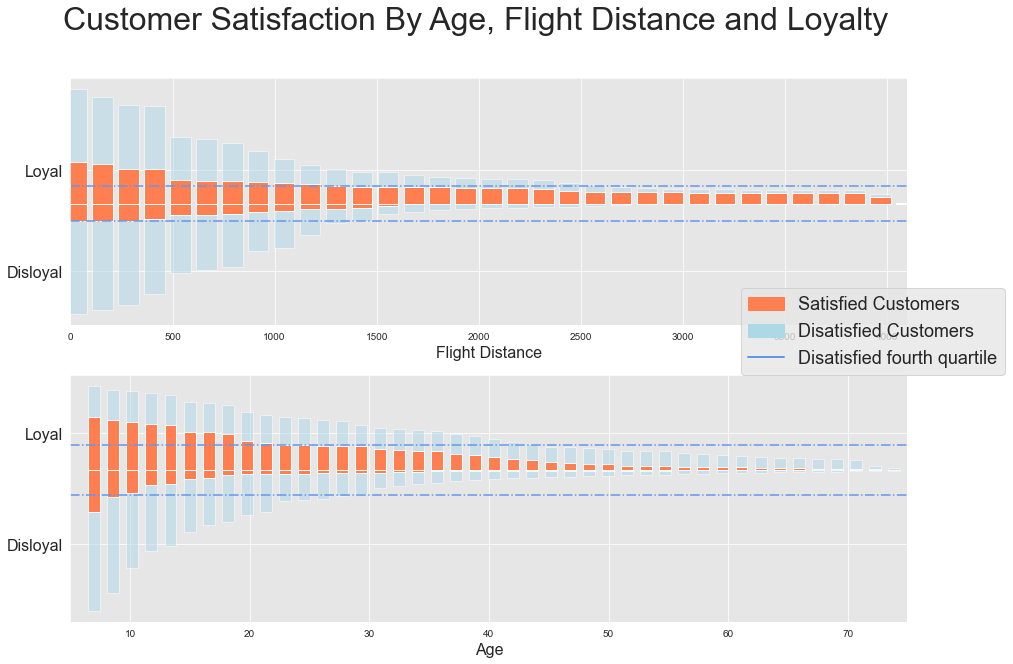

In [137]:
satisfied_patch = mpatches.Patch(color='coral', label='Satisfied Customers')
disatisfied_patch = mpatches.Patch(color='lightblue', label='Disatisfied Customers')
satisfied_quartile = Line2D([0],[0],color='cornflowerblue',lw=2,label='Disatisfied fourth quartile')

fig,axs = plt.subplots(2,1,figsize=(15,10))

axs[0].bar(x=flight_x_ticks,height=loyal_satisfied_flight_heights,color='coral',width=100)
axs[0].bar(x=flight_x_ticks,height=loyal_disatisfied_flight_heights,bottom=loyal_satisfied_flight_heights,
            color='lightblue',width=100,alpha=0.5)
axs[0].axhline(np.quantile(loyal_disatisfied_flight_heights,0.75),color='cornflowerblue',linestyle='-.')

axs[0].bar(x=flight_x_ticks,height=disloyal_satisfied_flight_heights,color='coral',width=100)
axs[0].bar(x=flight_x_ticks,height=disloyal_disatisfied_flight_heights,bottom=disloyal_satisfied_flight_heights,
            color='lightblue',width=100,alpha=0.5)
axs[0].axhline(np.quantile(disloyal_disatisfied_flight_heights,0.25),color='cornflowerblue',linestyle='-.')
axs[0].set_xlim(0,4100)
axs[0].set_yticks(ticks=[3000,-6000])
axs[0].set_yticklabels(['Loyal','Disloyal'],fontsize=16)
axs[0].set_xlabel("Flight Distance",fontsize=16)



axs[1].bar(x=age_x_ticks,height=loyal_satisfied_age_heights,color='coral',width=1)
axs[1].bar(x=age_x_ticks,height=loyal_disatisfied_age_heights,bottom=loyal_satisfied_age_heights,
            color='lightblue',width=1,alpha=0.5)
axs[1].axhline(np.quantile(loyal_disatisfied_age_heights,0.75),color='cornflowerblue',linestyle='-.')

axs[1].bar(x=age_x_ticks,height=disloyal_satisfied_age_heights,color='coral',width=1)
axs[1].bar(x=age_x_ticks,height=disloyal_disatisfied_age_heights,bottom=disloyal_satisfied_age_heights,
            color='lightblue',width=1,alpha=0.5)
axs[1].axhline(np.quantile(disloyal_disatisfied_age_heights,0.25),color='cornflowerblue',linestyle='-.')
axs[1].set_xlim(5,75)
axs[1].set_yticks(ticks=[2500,-5000])
axs[1].set_yticklabels(['Loyal','Disloyal'],fontsize=16)
axs[1].set_xlabel("Age",fontsize=16)

fig.legend(handles=[satisfied_patch,disatisfied_patch,satisfied_quartile],prop={'size':18},loc='center right')
fig.suptitle("Customer Satisfaction By Age, Flight Distance and Loyalty",fontsize=32)
plt.show()

Based on the figure above, the most disatisfaction to address is for flights shorter than 1500 miles, and customers under the age of 40. Its also interesting to not that there is just not much data on disloyal customers traveling farther than 2500 miles. 

Based on this figure I recommend focusing on improve checkin-in, boarding, and in-flight services for flights under 2000 miles and customers under age 40

# Conclussion

The data used in this analysis does not contain any information on the revenue or profits made from each ticket represented; there is some details on the flight itself and most of the data represents the subject satisfaction report of the customer represented. So it is impossible to make any recomendations at this point about how to drive profits, but it is posible to make recomendations on how to increase customer satisfaction and which populations within the market are the most disatisfied.  

The Random Forest feature importance showed that the age of the customer, wether the travel is for business or personal, the distance of the flight,and wether or not the customer was satisfeid were the most important features (in terms of the model making predictions) by a significant margin, so my broad strategy was to analyze the survey responses for based on various subsets of those features. 

The broad patterns I see are that disloyal customers are the most displeased with the process of actually getting on the plane, and some in-flight services need improvement. The most important groups to focus on improving services for is young adults (16-39) and business travel (all ages) based on rate of disatisfaction and market share. 

Specific pain points to investigate for improvement is the UX for online booking as well as online boarding. Customers are also very displeased with internet related services in-flight, specifically wifi and entertainment. Improving customer wifi service should improve satisfaction with entertainment as well. Customer accross the board are apathetic about cleanliness as well as food and drink. Seat comfort, of course, could use some improvement. Customer's are extremely disatisfied with departure/arival times, and gate locations, but I don't think there is much that can be done about these issues without serious cooperation and concession with other airlines. I believe more impactful change could be made quicker and more economically with the aformentioned pain points. 